<a href="https://colab.research.google.com/github/anammagalhaes/Data-Science-Projects-/blob/master/An%C3%A1lise_de_Risco_de_Cr%C3%A9dito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Desenvolvimento de um modelo de *Machine Learning* para Análise de Risco de Crédito**

## **Contextualização do problema**

A **taxa de inadimplência** dos clientes é um problema recorrente para bancos, financiadoras e empresários. 

Analisar o histórico financeiro e de pagamentos das pessoas é, portanto, de extrema relevância, uma vez que a inadimplência pode causar grandes impactos no balanço da Instituição. É por isso que cada vez mais vem sendo desenvolvidas soluções que tem como finalidade a minimização do risco de *default*. É a partir da análise de risco de crédito que uma Instituição pode definir se o cliente "merece" ou não sua confiança diante de pagamentos ou financiamentos. É normalmente feita quando o cliente solicita o serviço. 

O termo ***default*** é utilizado para indicar o não cumprimento das obrigações e/ou condições de um empréstimo, como financiamento ou dívidas de cartão de crédito, o que significa que, de fato, o cliente está inadimplente. 
 
Atualmente, grandes gancos e Fintechs apostam em modelos de *Machine Learning* para prevenir a inadimplência de seus clientes ou ainda, prever quais aqueles que podem vir a se tornar inadimplentes. 

O **objetivo** deste projeto é prever a probabilidade de um cliente da Fintech em não cumprir com suas obrigações financeiras e não pagar sua fatura de Cartão de Crédito. Ou seja, utilizando **Python**, **Data Science** e **Machine Learning** iremos criar um modelo, que baseado em dados históricos, indicará se o cliente poderá ser inadimplente futuramente. Desta forma, espera-se que o modelo seja capaz de minimizar as perdas financeiras da Fintech assim como os falsos positivos.  

Além disso, a finalidade maior é aplicar técnicas e ferramentas que me possibilitem a teoria e a prática, concomitantemente. Aprender e experimentar. 


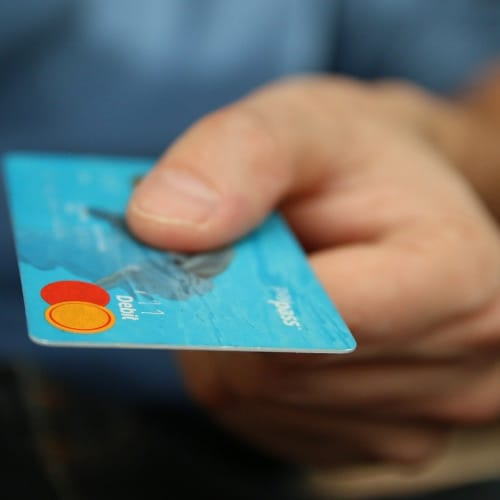

###Importando os Pacotes necessários e o Banco de Dados 

Os pacotes do Python que serão impoortados são alguns necessários para a análise exploratória e outros para a criação do modelo. 

In [21]:
# instalar Pandas Profiling
!pip install scikit-plot -q
!pip install imbalanced-learn -q

In [22]:
# importar os pacotes necessários 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from scikitplot.metrics import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# random seed
np.random.seed(42)

# definir o estilo do seaborn para os plots
sns.set_style()

# filtrar mensagens de warning
import warnings
warnings.filterwarnings('ignore')

O Banco de dados que será analisado foi retirado de uma competição realizada por uma Startup a fim de revelar talentos para contratações pela Fintech. Este banco de dados foi disponibilidado em formato csv no curso de Data Science da Sigmoidal. A partir do pacote Pandas podemos importar o csv e criar um DataFrame para possibilitar a sua manipulação e análise. 


In [23]:
df = pd.read_csv("http://dl.dropboxusercontent.com/s/xn2a4kzf0zer0xu/acquisition_train.csv?dl=0")

### Análise Exploratória 

Depois de criar o DataFrame, devemos examinar as suas dimensões, ou seja, quantidade de variáveis e de entradas. 

In [24]:
# Analisar a dimensão do dataset 

print("Dimensões do DataFrame:")
print("Entradas:\t{}".format(df.shape[0]))
print("Variáveis:\t{}".format(df.shape[1]))

Dimensões do DataFrame:
Entradas:	45000
Variáveis:	43


Desta forma, sabemos que é composto por 45 mil entradas, que são as linhas e 43 features (ou variáveis) que são as colunas. Imprimir as primeiras entradas do dataset nos permite também ter uma noção inicial de como os dados estão distribuidos e seus formatos, bem como estipular algumas hipóteses iniciais para as análises exploratórias. 

In [25]:
# Analisando as primeiras cinco primeiras entradas 

df.head()

,ids,target_default,score_1,score_2,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,reason,income,facebook_profile,state,zip,channel,job_name,real_state,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_applied,application_time_in_funnel,email,external_data_provider_credit_checks_last_2_year,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_first_name,external_data_provider_fraud_score,lat_lon,marketing_channel,profile_phone_number,reported_income,shipping_state,shipping_zip_code,profile_tags,user_agent,target_fraud
0,343b7e7b-2cf8-e508-b8fd-0a0285af30aa,False,1Rk8w4Ucd5yR3KcqZzLdow==,IOVu8au3ISbo6+zmfnYwMg==,350.0,101.800832,0.259555,108.427273,0.40,25033.92,36.0,0.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,65014.12,True,sjJbkqJS7cXalHLBFA+EOQ==,Ernn+uVXCMq/6ARrBCcd+A==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,N5/CE7lSkAfB04hVFFwllw==,NaN,0.0,0.0,18.0,18.0,07:52:34,444,outlook.com,NaN,2,0.0,51.0,leidelaura,645,"(-29.151545708122246, -51.1386461804385)",Invite-email,514-9840782,57849.0,BR-MT,17528,"{'tags': ['n19', 'n8']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...,NaN
1,bc2c7502-bbad-0f8c-39c3-94e881967124,False,DGCQep2AE5QRkNCshIAlFQ==,SaamrHMo23l/3TwXOWgVzw==,370.0,97.062615,0.942655,92.002546,0.24,NaN,NaN,39726.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,100018.91,False,xsd3ZdsI3356I3xMxZeiqQ==,rlWIXTBO+VOa34+SpGyhlQ==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,N5/CE7lSkAfB04hVFFwllw==,50.0,0.0,0.0,14.0,14.0,02:34:29,346,gmail.com,0.0,1,0.0,17.0,diocezio,243,"(-19.687710705798963, -47.94151536525154)",Radio-commercial,251-3659293,4902.0,BR-RS,40933,"{'tags': ['n6', 'n7', 'nim']}",Mozilla/5.0 (Linux; Android 5.0.2; SAMSUNG SM-...,NaN
2,669630dd-2e6a-0396-84bf-455e5009c922,True,DGCQep2AE5QRkNCshIAlFQ==,Fv28Bz0YRTVAT5kl1bAV6g==,360.0,100.027073,0.351918,112.892453,0.29,7207.92,36.0,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,65023.65,NaN,Ygq6MsM98oC8yceExr69Ig==,PjTIDfJsK0DKL9fO7vuW2g==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,n+xK9CfX0bCn77lClTWviw==,NaN,0.0,0.0,10.0,NaN,00:60:02,6,gmail.com,NaN,2,NaN,9.0,veralucia,65,"(-28.748023890412284, -51.867279334353995)",Waiting-list,230-6097993,163679.0,BR-RR,50985,"{'tags': ['n0', 'n17', 'nim', 'da']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...,NaN
3,d235609e-b6cb-0ccc-a329-d4f12e7ebdc1,False,1Rk8w4Ucd5yR3KcqZzLdow==,dCm9hFKfdRm7ej3jW+gyxw==,510.0,101.599485,0.987673,94.902491,0.32,NaN,NaN,54591.0,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,68830.01,False,KET/Pmr6rHp1RJ/P9ymztw==,Cc/kWDLQH3dpHv5HU+pLVA==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiE56f...,n+xK9CfX0bCn77lClTWviw==,NaN,1.0,0.0,19.0,19.0,11:20:49,406,spgov.com,NaN,3,NaN,38.0,venice,815,"(-17.520650158450454, -39.75801139933186)",Waiting-list,261-3543751,1086.0,BR-RN,37825,{'tags': ['n4']},Mozilla/5.0 (Linux; Android 6.0; HTC One X10 B...,NaN
4,9e0eb880-e8f4-3faa-67d8-f5cdd2b3932b,False,8k8UDR4Yx0qasAjkGrUZLw==,+CxEO4w7jv3QPI/BQbyqAA==,500.0,98.474289,0.532539,118.126207,0.18,NaN,NaN,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,60011.29,True,xsd3ZdsI3356I3xMxZeiqQ==,i036nmJ7rfxo+3EvCD7Jnw==,NCqL3QBx0pscDnx3ixKwXg==,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,n+xK9CfX0bCn77lClTWviw==,NaN,0.0,0.0,11.0,NaN,13:39:03,240,gmail.com,0.0,2,1.0,46.0,darzisa,320,"(-16.574259446978008, -39.90990074785962)",Invite-email,102-3660162,198618.0,BR-MT,52827,"{'tags': ['pro+aty', 'n19', 'da', 'b19']}",Mozilla/5.0 (Linux; Android 7.0; Pixel C Build...,NaN


Baseado nas primeiras entradas do dataset, algumas observações já podem ser feitas: 

A feature IDS representa um identificador para cada cliente. Mais adiante, esta 
coluna pode ser eliminada pois ela não apresenta informação relevante para o nosso estudo em questão.

  A coluna target_default apresenta a variável alvo para analisar o risco de default. É uma variável categórica e se divide em False e True. 

  As colunas ['score_3', 'score_4', 'score_5'] são numéricas e as colunas ['score_1', 'score_2'] estão codificadas. Além destas, outras variáveis também apresentam algum tipo de codificação, como é o caso de ['reason', 'state', 'zip', 'channel', 'job_name', 'real_state']. Nestes casos, são necessárias algumas análise posteriores e mais aprofundadas para identificar se é possível extrair alguma informação das mesmas e utilizá-las para gerar o modelo. 

  Aparentemente, a coluna profile_tags contém um dicionário com tags atribuídas a cada cliente.

  A coluna lat_lon está em formato string contendo uma tupla com as coordenadas.

  A coluna target_fraud pode ser a variável alvo de modelos com objetivo de onde o objetivo de detectar fraudes, por exemplo. Podemos notar que a partir de um dataset várias informações e modelos diferentes podem ser extraidos. 

  Por fim, pode ser que exista ainda outras considerações e hipóteses iniciais, no entanto, para este projeto, já possuimos observações necessárias para partir para as próximas análises exploratórias. 



Vamos realizar o levantamento dos tipos de variáveis que compõem o DataFrame a fim de estabelecer a divisão entre as variáveis numéricas e as variáveis categóricas. Isto será importante quando for treinar o modelo. 

In [26]:
# Tipo das variáveis 

print("\nTipos das variáveis")
print(df.dtypes)


Tipos das variáveis
ids                                                  object
target_default                                       object
score_1                                              object
score_2                                              object
score_3                                             float64
score_4                                             float64
score_5                                             float64
score_6                                             float64
risk_rate                                           float64
last_amount_borrowed                                float64
last_borrowed_in_months                             float64
credit_limit                                        float64
reason                                               object
income                                              float64
facebook_profile                                     object
state                                                object
zip                

Podemos ver que as variáveis numéricas são float ou int e a variável alvo, categórica, que é target_default é object. 

### Análise Estatística 

É importante também imprimir um resumo estatístico do dataset a fim de analisar a média, mediana, distribuição dos dados nas features. 

In [27]:
# imprimir resumo estatístico dos dados numéricos 

df.describe()

,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,income,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_in_funnel,external_data_provider_credit_checks_last_2_year,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_fraud_score,reported_income,shipping_zip_code
count,44438.000000,45000.000000,45000.000000,45000.000000,44438.000000,15044.000000,15044.000000,31200.000000,4.443800e+04,18455.000000,44303.000000,44426.000000,44438.000000,33456.000000,45000.000000,22372.0,45000.000000,29876.000000,42767.000000,45000.000000,45000.00,45000.000000
mean,347.983258,100.006797,0.500037,99.925228,0.296717,13782.341991,41.763893,34381.951154,7.160739e+04,35.069737,0.076270,0.004569,10.696701,11.068119,247.537000,0.0,1.501067,0.503381,12.534781,500.399800,inf,33923.514844
std,110.429165,3.178080,0.288326,10.016549,0.101933,8077.571933,10.252705,36586.982218,5.185897e+04,21.663194,0.274052,0.079400,4.592463,4.595501,146.118398,0.0,1.114941,0.499997,126.530487,287.968873,NaN,12692.406382
min,0.000000,86.191572,0.000035,60.663039,0.000000,1005.180000,36.000000,0.000000,4.821180e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,-999.000000,0.000000,403.00,12001.000000
25%,270.000000,97.867036,0.252150,93.198353,0.220000,7519.502500,36.000000,10000.000000,4.501078e+04,17.000000,0.000000,0.000000,7.000000,8.000000,120.000000,0.0,1.000000,0.000000,11.000000,252.000000,50948.25,22937.000000
50%,340.000000,100.018900,0.500753,99.974796,0.290000,12023.465000,36.000000,25647.000000,6.126676e+04,32.000000,0.000000,0.000000,10.000000,10.000000,248.000000,0.0,2.000000,1.000000,27.000000,503.000000,101779.00,33896.000000
75%,420.000000,102.141797,0.748816,106.640275,0.360000,19220.270000,36.000000,47086.750000,8.601923e+04,50.000000,0.000000,0.000000,13.000000,14.000000,375.000000,0.0,2.000000,1.000000,43.000000,747.000000,151337.25,44910.000000
max,990.000000,113.978234,0.999973,142.192400,0.900000,35059.600000,60.000000,448269.000000,5.000028e+06,141.000000,5.000000,5.000000,49.000000,49.000000,500.000000,0.0,3.000000,1.000000,59.000000,1000.000000,inf,56000.000000


Podemos observar que: 

A coluna external_data_provider_credit_checks_last_2_year possui valores mínimos, máximos e desvio-padrão iguais a zero.

A feature reported_income apresenta valores dados como "inf", que irão interferir na análise e modelo. Portanto, serão substituidos por np.nan para trabalhar com os dados.

A coluna external_data_provider_email_seen_before apresenta o valor mínimo de -999, o que não faz sentido ao se considerar as outras informações. Assim, pode ser que estes dados são outliers ou então, foram tratados inadequadamente. Substituiremos os valores iguais a -999 por np.nan.



In [28]:
# Identificando dados ausentes em cada feature (calculei e depois criei um dataframe com o que foi calculado, depois coloquei esse dataframe com o formato de porcentagem)
 
n=(df.isnull().sum()/df.shape[0]).sort_values(ascending=False)
df_n = pd.DataFrame(n)
df_n.style.format(" {:.2%}")


,0
target_fraud,96.62%
last_amount_borrowed,66.57%
last_borrowed_in_months,66.57%
ok_since,58.99%
external_data_provider_credit_checks_last_2_year,50.28%
external_data_provider_credit_checks_last_year,33.61%
credit_limit,30.67%
n_issues,25.65%
facebook_profile,9.91%
marketing_channel,7.95%


Ou seja, algumas variáveis apresentam muitos valores ausentes, como é o caso de target_fraud, last_amount_borrowed, last_borrowed_in_months, ok_since, external_data_provider_credit_checks_last_2_year as quais apresentam mais da metade de seus dados, ausentes. Isto é preocupante se estas features forem importantes para a análise. Logo em seguida em porcentagem estão as variáveis external_data_provider_credit_checks_last_year, credit_limit, n_issues possuem entre 25-34% do seus valores ausentes.
No caso, a variável que possui maior número de valores ausentes que é target_fraud será eliminada do dataset por não influenciar em nossa análise e modelo de risco de inadimplência. Por outro lado, os valores ausentes da variável alvo, que é target_default vão ser eliminados do dataset. 

Uma outra análise interessante de se fazer diz respeito à contagem de valore únicos por features. Muitas vezes, variáveis numéricas podem esconder classes/categorias que melhor representariam uma feature, ou revelar uma quantidade elevada de classes para  "variáveis categóricas".

In [29]:
# valores únicos
print("\nValores Únicos:")
print(df.nunique().sort_values())


Valores Únicos:
external_data_provider_credit_checks_last_2_year        1
channel                                                 1
target_fraud                                            2
target_default                                          2
external_data_provider_credit_checks_last_year          2
facebook_profile                                        2
last_borrowed_in_months                                 2
external_data_provider_credit_checks_last_month         4
n_defaulted_loans                                       5
real_state                                              5
email                                                   6
n_bankruptcies                                          6
score_1                                                 7
marketing_channel                                       9
shipping_state                                         25
score_2                                                35
n_issues                                               

A contagem de valores únicos mostra que as colunas external_data_provider_credit_checks_last_2_year e channel apresentam um único valor possível. Como não ha maiores informações sobre cada feature iremos descartar as duas colunas para o modelo de Machine Learning.

Também se percebe que profile_phone_number possui 45 mil valores únicos, não trazendo provavelmente nenhuma informação que possa contribuir para a análise.


Como já mencionado, a feature target_default traz infomações de inadimplentes e está representada pelas classes True e False. É importante para treinar o modelo analisar qual é a proporção destas classes para que se tiver desbalanceamento, tratar depois. 

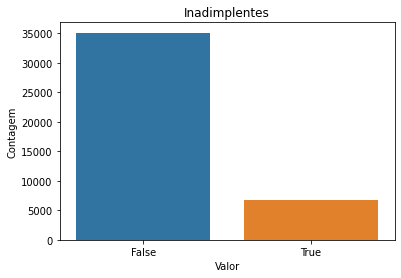

Proporção entre Inadimplentes no Dataset:
False    0.779556
True     0.148022
Name: target_default, dtype: float64


In [30]:
# Proporção entre Inadimplentes no Dataset

fig, ax = plt.subplots()
sns.countplot('target_default', data=df, ax=ax)
ax.set_title("Inadimplentes")
ax.set_xlabel("Valor")
ax.set_ylabel("Contagem")
plt.show()

print("Proporção entre Inadimplentes no Dataset:")
print(df['target_default'].value_counts() / df.shape[0])

Aqui verificamos que a proporção de False (77%)  é bem maior que a de True (14%). 

### Preparação dos dados para treinar o modelo

Com as informações extraidas anteriormente do dataset, seguiremos fazendo etapas dea limpeza e tratamento dos dados a fim de prepará-los para o treinamento do modelo. A seguir, algumas destas etapas: 

In [31]:
df_clean = df.copy()

# substituir inf por nan em reported_income 

df_clean['reported_income'] = df_clean['reported_income'].replace(np.inf, np.nan)

#descartar as colunas ids, target_fraud, external_data_provider_credit_checks_last2_year e channel
df_clean.drop(labels=['ids', 'target_fraud',
                      'external_data_provider_credit_checks_last_2_year',
                      'channel'], axis=1, inplace=True)

# substituir -999 em external_data_provider_email_seen_before por NaN #MAS COMO SABIA QUE TINHA ESSE -999? 
df_clean.loc[df_clean['external_data_provider_email_seen_before'] == -999.0,
             'external_data_provider_email_seen_before'] = np.nan

# elminar colunas sem informação aparente ou que demandam mais pesquisa
drop_var = ['reason', 'zip', 'job_name', 'external_data_provider_first_name',
            'lat_lon', 'shipping_zip_code', 'user_agent', 'profile_tags',
            'application_time_applied', 'email', 'marketing_channel',
            'profile_phone_number', 'shipping_state']
df_clean.drop(labels=drop_var, axis=1, inplace=True) 

# eliminar as entradas onde target_defaut é NaN
df_clean.dropna(subset=['target_default'], inplace=True)

Apesar de não haver maiores informações sobre as features, podemos assumir como premissa que muitos valores são nulos (NaN) devido à alguns fatores, como:

Há alguns itens que não são obrigatórios de serem preenchidos em formulários, valores ausentes nas colunas last_amount_borrowed, last_borrowed_in_months, n_issues vão ser substituidos por zero. 

Para as variáveis numéricas, serão substituidos pela mediana e na variável categórica será substituido pelo valor mais frequente. 


In [32]:
from sklearn.impute import SimpleImputer

num_df = df_clean.select_dtypes(exclude='object').columns
cat_df = df_clean.select_dtypes(include='object').columns

# substituição de valores ausentes (as que não foram preenchidas, substitui por zero)
df_clean.last_amount_borrowed.fillna(value=0, inplace=True)
df_clean.last_borrowed_in_months.fillna(value=0, inplace=True)
df_clean.n_issues.fillna(value=0, inplace=True)

# variáveis numéricas (onde não foi preenchido, será substituido pela mediana)
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
imputer = imputer.fit(df_clean.loc[:,num_df])
df_clean.loc[:,num_df] = imputer.transform(df_clean.loc[:,num_df])

# variáveis categóricas
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputer = imputer.fit(df_clean.loc[:,cat_df])
df_clean.loc[:,cat_df] = imputer.transform(df_clean.loc[:,cat_df])

Podemos agora verificar que as variáveis escolhidas não possuem mais os valores nulos iniciais.


In [33]:
# verificar a quantidade de dados nulos
df_clean.isnull().sum()

target_default                                     0
score_1                                            0
score_2                                            0
score_3                                            0
score_4                                            0
score_5                                            0
score_6                                            0
risk_rate                                          0
last_amount_borrowed                               0
last_borrowed_in_months                            0
credit_limit                                       0
income                                             0
facebook_profile                                   0
state                                              0
real_state                                         0
ok_since                                           0
n_bankruptcies                                     0
n_defaulted_loans                                  0
n_accounts                                    

ou seja, depois da limpeza, não há features que apresente valores nulos. 

Para melhorar o desempenho do modelo, é necessário padronizar as variáveis numéricas usando StandartScaler. 

In [34]:
# criando uma cópia do df
scaled_df = df_clean.copy()

# normalizar as colunas numéricas (num_cols)
num_cols = scaled_df.drop('target_default',
                         axis=1).select_dtypes(exclude='object').columns

scaled_df[num_cols] = StandardScaler().fit_transform(scaled_df[num_cols].values)

Continuando com a preparação dos dados, será utilizado o Label Encoding para possibilitar que as variáveis categóricas possam ser codificadas em forma de labels e alimentar o modelo de Machine Learning.

In [35]:
# criando uma cópia do df
encoded_df = scaled_df.copy()

# extrair as colunas categóricas
cat_cols = encoded_df.select_dtypes('object').columns

# codificar cada coluna categórica
for col in cat_cols:
  encoded_df[col+'_encoded'] = LabelEncoder().fit_transform(encoded_df[col])
  encoded_df.drop(col, axis=1, inplace=True)

Por fim, irei separar a variável alvo das demais e dividir o dataset entre dados de treino e teste com a função train_test_split.

In [36]:
# separar as variáveis independentes da variável alvo
X = encoded_df.drop('target_default', axis=1).select_dtypes(exclude='object')
y = encoded_df['target_default']

# dividir o dataset entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Construção do modelo 

O objetivo é comparar a performance de diferentes modelos de Classificação. Desta forma, foi primeiro, criada uma baseline, funciona como uma métrica para estabelecer qual o melhor modelo para aquele problema. Foi escolhido o RandomForestClassifier como baseline, de modo arbitrário e não parametrizado. 






## Métricas e modelos 

A métrica de avaliação da performance de um modelo deve ser definido de acordo com as estratégias e valores da empresa, por exemplo. No entanto, a acurácia é a métrica mais generalista e mais comumente utilizada para ditar se há ou não uma boa performance do modelo. Outra métrica é o Recall que, por exemplo, prioriza que não haja Falsos Negativos, o que é bastante utilizado em modelos de fraudes em cartão de crétito e em modelos médicos. Explicando de forma bastante simples, é como se fosse preferivel negar um cliente que não traria prejuízo à empresa, do que aceitar um que traga, essa é a premissa do Recall. 
Caso optemos por otimizar  a partir do Precision, essencialmente afirmando que Falsos Positivos  são importantes na análise e não queremos ter Falsos Negativos. Basicamente, é preferível aceitar clientes que possam trazer prejuízo, do que deixar de aceitar clientes que não trarão. 

In [37]:
# construindo função de avaliação do baseline


def val_model(X, y, clf, quite=False):
    """
    Realiza cross-validation com os dados de treino para determinado modelo.

    # Arguments
        X: DataFrame, contém as variáveis independetes.
        y: Series, vetor contendo a variável alvo.
        clf: modelo classificador do Scikit-learn.
        quite: bool, indicando se a função deve imprimir os resultados ou não.

    # Returns
        float, média dos scores da cross-validation.
    """
    
    X = np.array(X)
    y = np.array(y)

    pipeline = make_pipeline(StandardScaler(), clf)
    scores = cross_val_score(pipeline, X, y, scoring='accuracy')

    if quite == False:
        print("Acurácia: {:.4f} (+/- {:.2f})".format(scores.mean(), scores.std()))
    
    return scores.mean()

# criar baseline e ver desempenho (porque ele fez x train e y train?? não era teste?)
rf = RandomForestClassifier()
score_baseline = val_model(X_train, y_train, rf)



Acurácia: 0.8381 (+/- 0.00)


Esta foi a acurácia da baseline, sem nenhum tuning de hiperparâmetros. A seguir são testados outros modelos: 


    Random Forest Classifier (Baseline)
    Decision Tree Classifier
    SGD Classifier
    SVC
    Logistic Regression
    XGB Classifier
    LGBM Classifier


In [41]:
# instanciar modelos
rf = RandomForestClassifier()
dt = DecisionTreeClassifier()
sgdc = SGDClassifier()
svc = SVC()
lr = LogisticRegression()
xgb = XGBClassifier()
lgbm = LGBMClassifier()

model = []
acc = []
# avaliar o desempenho
for clf in (rf, dt, sgdc, svc, lr, xgb, lgbm):
    model.append(clf.__class__.__name__)
    acc.append(val_model(X_train, y_train, clf, quite=True))

pd.DataFrame(data=acc, index=model, columns=['acc'])

,acc
RandomForestClassifier,0.837600
DecisionTreeClassifier,0.738688
SGDClassifier,0.837053
SVC,0.837292
LogisticRegression,0.837087
XGBClassifier,0.838764
LGBMClassifier,0.838422


Os modelos foram então testados, agora será analizadas as acurácias de cada um. 

Ao realizar os testes com diferentes modelos, podemos ver que o XGBClassifierretornou os melhores resultados.

A margem foi pequena, o que suegere que, dada a devida parametrização, qualquer modelo dessa lista poderia ser tão eficiente ou até mais eficiente do que o XGB, mas devido ao seu resultado inicial, iremos seguir com ele.

No entanto, identificando melhores parâmetros com get_params podemos dar um tunar estes parâmetros e melhorar o XGBClassifier. 



https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e

In [42]:
# verificando os parâmetros
xgb.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}

In [43]:
# instanciando o modelo
xgb = XGBClassifier(random_state=42)

# definindo os parâmetros a serem testados  
param_grid = {
  'learning_rate': [0.001, 0.01, 0.1],  
  'gamma':[0, 1, 5],
  'subsample':[0.5, 1.5, 3.5],
  'max_depth': [1, 3, 5],
  'n_estimators': [100, 500, 1000],
  'colsample_bytree': [0.1, 0.5, 1]
 }

In [ ]:
# identificar melhores parâmetros
kfold = StratifiedKFold(n_splits=3, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="accuracy", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)

# ver resultados
print("Melhor: {:.2f} para {}".format(grid_result.best_score_, grid_result.best_params_))

In [ ]:
# instanciando o modelo e treinando o mesmo
ml_model = XGBClassifier(learning_rate=0.1, max_depth=1, gamma=5,
                         n_estimators= 1000, min_child_weight=1, 
                         subsample = 0.5, colsample_bytree = 0.1,
                         random_state=42)

ml_model.fit(X_train, y_train)

In [ ]:
# previsões e probabilidades em cima do dataset de teste
y_pred = ml_model.predict(X_test)

# imprimir a acurácia do modelo
print("Acurácia: {:.4f}\n".format(accuracy_score(y_test, y_pred)))

### Conclusões gerais 



Nesse projeto, o objetivo era realmente comparar o desempenho, pela acurácia, de diferentes modelos. Foi verificado que, com acurácia igual a 0.838764, o XGBClassifier foi identificado como o melhor dentre os demais analisados. No entanto, a diferença de desempenho entre os modelos foi relativamente pequena,  o que, usar os outros modelos em determinados casos e problemas pode influenciar bastante no resultado de predição e em outros, não. 
Foi analisado também que melhora o resultado quando escolhidos e "tunados" os parâmetros. 


